<a href="https://colab.research.google.com/github/shreyus3003/CMPE297_sec49/blob/master/Assignment_1_Part_1/Assign1_part1_MIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-instance Learning:
MIL is a supervised learning where bags or groups of samples are labeled. This means that the individual examples are unlabeled.
This could be very useful in Medical field for example, in identifing cancer cells.
A bag is considered positive if atleast one instance in the bag is positive and negative if all the instances are negative.

The below code illustarte a MIL model where we use MNIST dataset for simple implementation. We only take few images for this purpose from the dataset.
This is a pytorch implementation.

In [133]:
# Import all the libraries required for pytorch and metrics display.
import os 
import tensorflow as tf
import time 

import numpy as np
import pandas as pd

import torch
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from torch import nn, optim
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torch.utils.data import DataLoader

import inspect
import tensorflow as tf

from tqdm.autonotebook import tqdm

import warnings
warnings.filterwarnings('ignore')


We use GPU to train the model if available else CPU is use.

In [134]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start_ts = time.time()

## Define a Model
Use resenet model to define a simple model.

In [135]:
class M_resnet(ResNet):
  def __init__(self):
    super(M_resnet, self).__init__(BasicBlock, [2,2,2,2], num_classes = 10)
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size = (7,7), stride=(2,2), padding=(3,3), bias=False)
  
  def forward(self, x):
    return torch.softmax(super(M_resnet, self).forward(x), dim=-1)

Functions to calculate and display the metrics is defined.


In [136]:
def metrics_cal( metric_fn, true_y, pred_y):
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)

# def display_scores(p, r, f1, a, batch_size):
#   for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p,r,f1,a)):
#     print(f"\t{name.rjust(14,' ')}: {sum(scores)/batch_size:4f}")

def display_scores(p, r, f1, a, batch_size):
  a = (np.sum(a)/batch_size)
  # print(a)
  print(f"\tAccuracy: {a:4f}")


## Load the MNIST dataset:
Mnist dataset is loaded and as we are considering only few sample images for the faster training of the model, we use 15K samples of training data and 4K samples of validation data.

In [ ]:
def load_data(train_batch_size, val_batch_size):
  mnist = MNIST(download=True, train=True, root=".").train_data.float()
  d_transform = Compose([Resize((224,224)), ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])
  dataset_train = MNIST(download=True, root=".", transform=d_transform, train=True)
  dataset_val = MNIST(download=False, root=".", transform=d_transform, train=False)
  
  train_set, a  = torch.utils.data.random_split(dataset_train, [15000, 45000])
  val_set, b = torch.utils.data.random_split(dataset_val, [4000,6000])

  train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=val_batch_size, shuffle=False)
  return train_loader, val_loader

In [137]:
train_batch_size = 256
val_batch_size = 256

train_loader, valid_loader = load_data(train_batch_size, val_batch_size)

Load the model defined above and train the model. Use 6 epochs to train. The training metrics are displayed.

In [138]:
# Load the model:
model = M_resnet().to(device)

epochs = 6
train_loader, val_loader = load_data(train_batch_size, val_batch_size)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adadelta(model.parameters())

losses = []
batches = len(train_loader)
val_batches = len(val_loader)
print(batches)
val_batches

for epoch in range(epochs):
  total_loss = 0

  progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
  model.train()

  for i, data in progress:
    X, y = data[0].to(device), data[1].to(device)
    model.zero_grad()

    outputs = model(X)
    loss = loss_function(outputs, y)
    loss.backward()
    optimizer.step()
    current_loss = loss.item()
    total_loss += current_loss

    progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

  if torch.cuda.is_available():
    torch.cuda.empty_cache()

  val_losses = 0
  precision, recall, f1, accuracy = [], [], [], []

  model.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      X, y = data[0].to(device), data[1].to(device)

      outputs = model(X)
      val_losses += loss_function(outputs, y)
      predicted_classses = torch.max(outputs, 1)[1]

      for acc, metric in zip((precision, recall, f1, accuracy),
                             (precision_score, recall_score, f1_score, accuracy_score)):
        acc.append(metrics_cal(metric, y.cpu(), predicted_classses.cpu()))

  print(f"epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss : {val_losses/val_batches}")
  display_scores(precision, recall, f1, accuracy, val_batches)
  losses.append(total_loss/batches)
print(f"Training time : {time.time()-start_ts}s")        
    


59



epoch 1/6, training loss: 1.9146391133130607, validation loss : 1.8660717010498047
	Accuracy: 0.604590



epoch 2/6, training loss: 1.566627114506091, validation loss : 1.6792722940444946
	Accuracy: 0.818750



epoch 3/6, training loss: 1.4907884941262715, validation loss : 1.5415740013122559
	Accuracy: 0.933545



epoch 4/6, training loss: 1.4791653439150019, validation loss : 1.5082403421401978
	Accuracy: 0.963672



epoch 5/6, training loss: 1.4746139635473996, validation loss : 1.5810800790786743
	Accuracy: 0.889355



epoch 6/6, training loss: 1.470792139990855, validation loss : 1.5545800924301147
	Accuracy: 0.921680
Training time : 588.1497838497162s


Save the model.

In [13]:
torch.save(model.state_dict(), 'supervis_mnist.pt')

## Load MNIST dataset:
Mnist dataset is loaded using keras for creating the bags and groups out of the samples. we use 14k trainig samples and 3k validation samples to create bags.



In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [15]:
x_train = x_train[:14001]
y_train = y_train[:14001]

x_test = x_test[:3000]
y_test = y_test[:3000]

In [17]:
# Normalize the data.

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 225
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: (14001, 28, 28)
x_test: (3000, 28, 28)


## Create bags
In this example we create bags such that the bag label is assigned as 1 if 1 of the instance has one. bag label is zero if the labels are 0-9 other than 1. Below we create the bags.

In [ ]:
inst_index_label = [(i, y_train[i]) for i in range(x_train.shape[0])]
inst_index_label_test = [(i, y_test[i]) for i in range(x_test.shape[0])]
inst_index_label

In [21]:
f_index = [inst_index_label[i][0] for i in range(len(inst_index_label)) if inst_index_label[i][1]==1]
f_index_test = [inst_index_label_test[i][0] for i in range(len(inst_index_label_test)) if inst_index_label_test[i][1]==1]

Load the model which was trained and saved earlier with 14k mnist samples. Extract the last layer for using it to get the features.

In [27]:
model = M_resnet()
model.load_state_dict(torch.load('/content/supervis_mnist.pt'))
body = nn.Sequential(*list(model.children()))
model = body[:9]
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# Extract Features

In [28]:
train_batch_size = 1
val_batch_size = 1
train_loader, val_loader = load_data(train_batch_size, val_batch_size)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adadelta(model.parameters())

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [29]:
losses = []
batches = len(train_loader)
val_batches = len(val_loader)

#Extract features for train:
Obtain the features from the previously trained model and save it as f_array.

In [30]:
meta_table = dict()
feature_res = []

progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

model.eval()
for i, data in progress:
  if i == 14001:
    break
  X, y = data[0], data[1]
  model.zero_grad()
  outputs = model(X)
  feature_res.append(outputs.reshape(-1).tolist())
  meta_table[i] = outputs.reshape(-1).tolist()

f_array = np.array(feature_res)
np.save('f_array_full', f_array)

In [61]:
f_array = np.load('/content/f_array_full.npy', allow_pickle=True)

# Extract Features for test:

In [34]:
meta_table = dict()
f_test_res = []

progress = tqdm(enumerate(val_loader), desc="Loss: ", total=val_batches)

model.eval()
for i, data in progress:
  if i == 3000:
    break
  X, y = data[0], data[1]
  model.zero_grad()
  outputs = model(X)
  f_test_res.append(outputs.reshape(-1).tolist())
  meta_table[i] = outputs.reshape(-1).tolist()

ft_array = np.array(f_test_res)
np.save('ft_array_full', ft_array)

In [60]:
ft_array = np.load('/content/drive/My Drive/assign1_DL/ft_array_full.npy', allow_pickle=True)

In [37]:
# ! cp /content/f_array_full.npy "/content/drive/My Drive/assign1_DL"
# ! cp /content/ft_array_full.npy "/content/drive/My Drive/assign1_DL"

# Create training Data:
Training data is created obtaining the bag instances, labes and features.

In [76]:
from typing import List, Dict, Tuple
import copy

def gen_data(inst_index_label: List[Tuple]) -> List[Dict]:
  bag_size = np.random.randint(3,7,size=(len(inst_index_label))//5)
    
  data_cp = copy.copy(inst_index_label)
  np.random.shuffle(data_cp)
  bags = {}
  bags_per_instance_labels = {}
  bags_labels = {}
  
  for bag_ind, size in enumerate(bag_size):
      bags[bag_ind] = []
      bags_per_instance_labels[bag_ind] = []
      try:
          for _ in range(size):
              inst_ind, lbl = data_cp.pop()
              bags[bag_ind].append(inst_ind)
              bags_per_instance_labels[bag_ind].append(lbl)
          bags_labels[bag_ind] = bag_label_from_instance_labels(bags_per_instance_labels[bag_ind])
      except:
          break
  return bags, bags_labels

def bag_label_from_instance_labels(instance_labels):
    return int(any(((x==1) for x in instance_labels)))
                          

In [ ]:
bag_indices, bag_labels = gen_data(inst_index_label)
#print(feature_array)

bag_features = {kk: torch.Tensor(f_array[inds]) for kk, inds in bag_indices.items()}
print(bag_features)

In [80]:
bag_t_indices, bag_t_labels = gen_data(inst_index_label_test)
bag_t_features = {kk: torch.Tensor(ft_array[inds]) for kk, inds in bag_t_indices.items()}

In [47]:
! cd /content/

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [84]:
train_data = [(bag_features[i],bag_labels[i]) for i in range(len(bag_features))]
bag_features[0]

tensor([[1.1818, 1.2626, 1.9718,  ..., 0.9811, 0.7399, 0.6508],
        [1.7176, 0.0720, 1.0232,  ..., 0.0195, 0.1820, 0.7949],
        [0.7418, 0.0864, 0.1953,  ..., 0.1456, 0.0810, 0.1549],
        [0.2397, 1.8663, 0.8743,  ..., 1.8743, 0.9468, 0.4713]])

Padding is done on each tensor to have the same shape, as the bag will be of different sizes

In [85]:
def pad_tensor(data:list, max_number_instance) -> list:
    new_data = []
    for bag_index in range(len(data)):
        tensor_size = len(data[bag_index][0])
        pad_size = max_number_instance - tensor_size
        p2d = (0,0, 0, pad_size)
        padded = nn.functional.pad(data[bag_index][0], p2d, 'constant', 0)
        new_data.append((padded, data[bag_index][1]))
    return new_data

In [86]:
max_number_instance = 7
padded_train = pad_tensor(train_data, max_number_instance)

In [87]:
test_data = [(bag_t_features[i],bag_t_labels[i]) for i in range(len(bag_t_features))]
padded_test = pad_tensor(test_data, max_number_instance)

In [88]:
def load_data(train_data, test_data, train_batch_size, val_batch_size):
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [90]:
train_loader,valid_loader = load_data(padded_train, padded_test, 1, 1)
train_batch_size = 1
val_batch_size = 1

Define the multi-instance model using torch nn module

In [97]:
class NN(torch.nn.Module):

    def __init__(self, n=7*512, n_mid = 7168, n_out=1, dropout=0.2):
        super(NN, self).__init__()
        self.linear1 = torch.nn.Linear(n, n_mid)
        self.linear2 = torch.nn.Linear(n_mid, n_out)
        self.dropout = torch.nn.Dropout(dropout)
        self.non_linearity = torch.nn.LeakyReLU()
        
    def forward(self, x):
        z = self.linear1(x)
        z = self.non_linearity(z)
        z = self.dropout(z)
        z = self.linear2(z)
        y_pred = torch.sigmoid(z)
        return y_pred

class NoisyAnd(torch.nn.Module):
    def __init__(self, a=10, dims=[0]):
        super(NoisyAnd, self).__init__()
        self.a = a
        self.b = torch.nn.Parameter(torch.tensor(0.01))
        self.dims =dims
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        mean = torch.mean(x, self.dims, False)
        res = (self.sigmoid(self.a * (mean - self.b)) - self.sigmoid(-self.a * self.b)) / (
              self.sigmoid(self.a * (1 - self.b)) - self.sigmoid(-self.a * self.b))
        return res
    

class MIL_NN(torch.nn.Module):

    def __init__(self, n=7*512,  n_mid=7168, n_out=1, 
                 n_inst=None, dropout=0.1,
                 noisy_a=4,
                 agg = NoisyAnd(a=4, dims=[0]),
                ):
        super(MIL_NN, self).__init__()
        if agg is None:
            agg = NoisyAnd(a=noisy_a, dims=[0])
        if n_inst is None:
            self.mdl_instance = agg
            n_inst = n
        else:
            self.mdl_instance = nn.Sequential(
                            nn.Linear(n, n_inst),
                            nn.LeakyReLU(),
                            agg,
                            )
        if n_mid == 0:
            self.mdl_bag = LogisticRegression(n_inst, n_out)
        else:
            self.mdl_bag = NN(n_inst, n_mid, n_out, dropout=dropout)
        
    def forward(self, bag_feature):

        y_pred = self.mdl_bag(bag_feature)
        return y_pred

Helper functions to plot the train and validationa losses and display the results.

In [129]:
import matplotlib.pyplot as plt

def display_scores(p, r, f1, a, batch_size):
  a = (np.sum(a)/batch_size)
  # print(a)
  print(f"\tAccuracy: {a:4f}")
  
  # for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p,r,f1,a)):
  # for name, scores in zip(("accuracy"), (a)):
  #   print(name)
  #   print(scores)
  #   print(f"\t{name.rjust(14,' ')}: {sum(scores)/batch_size:4f}")

def plot_validation(tr_loss, tes_loss):
  epoch_count = range(1, len(tr_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, tr_loss, 'r--')
  plt.plot(epoch_count, tes_loss, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

Load the MIL model, traun for 10 epochs and evaluate the model. The results are as shown below along with the plot which shows the loasses.

In [131]:
import warnings
warnings.filterwarnings('ignore')
lr0 = 1e-4

model = MIL_NN().to(device)

epochs = 10
train_loader, val_loader = load_data(padded_train, padded_test, 1, 1)
loss_function = torch.nn.BCELoss(reduction='mean')      


optimizer = optim.SGD(model.parameters(), lr=lr0, momentum=0.9)

losses = []
batches = len(train_loader)
val_batches = len(val_loader)
t_loss = []
v_loss = []

for epoch in range(epochs):
    total_loss = 0


    # progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)


    model.train()
    # for i, data in progress:
    for i, data in enumerate(train_loader):
        X, y = data[0].to(device), data[1].to(device)
        X = X.reshape([1,7*512])
        y = y.type(torch.cuda.FloatTensor)
      
        model.zero_grad()

        outputs = model(X)                             
        loss = loss_function(outputs, y)               
        loss.backward()                                
        optimizer.step()                            

        
        current_loss = loss.item()
        total_loss += current_loss

     
        # progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            X = X.reshape([1,7*512])
            y = y.type(torch.cuda.FloatTensor)
            outputs = model(X)                        
            prediced_classes =outputs.detach().round()
            val_losses += loss_function(outputs, y)
            
            
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    metrics_cal(metric, y.cpu(), prediced_classes.cpu())
                )
    t_loss.append(total_loss/batches)
    v_loss.append(val_losses/val_batches)   
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    display_scores(precision, recall, f1, accuracy, val_batches)

    # print_scores(accuracy, val_batches)
    losses.append(total_loss/batches)                  
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/10, training loss: 0.7288772944520627, validation loss: 0.752399206161499
	Accuracy: 0.531667
Epoch 2/10, training loss: 0.6815123235860041, validation loss: 0.6914316415786743
	Accuracy: 0.573333
Epoch 3/10, training loss: 0.6632336030261857, validation loss: 0.6915848851203918
	Accuracy: 0.566667
Epoch 4/10, training loss: 0.6548186377728624, validation loss: 0.6848378777503967
	Accuracy: 0.576667
Epoch 5/10, training loss: 0.6416550201656563, validation loss: 0.7100945115089417
	Accuracy: 0.551667
Epoch 6/10, training loss: 0.6323641132962491, validation loss: 0.7179750204086304
	Accuracy: 0.561667
Epoch 7/10, training loss: 0.6215595753051872, validation loss: 0.7536075711250305
	Accuracy: 0.493333
Epoch 8/10, training loss: 0.6122215927046325, validation loss: 0.7227935194969177
	Accuracy: 0.560000
Epoch 9/10, training loss: 0.5999849742424808, validation loss: 0.7370573878288269
	Accuracy: 0.561667
Epoch 10/10, training loss: 0.5944194277469069, validation loss: 0.7496514

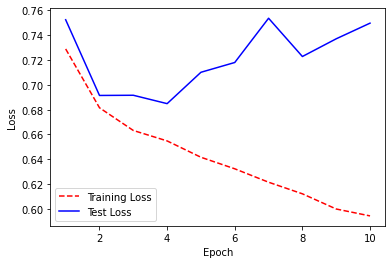

In [132]:
plot_validation(t_loss, v_loss)

The above plot shows the train and validations losses for the MIL model. The training was performed on limited data and hence the model perfoemance is not high. 